# Severstal: Steel Defect Detection

Сталь - один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместным во всем мире. В этом соревновании вы поможете инженерам улучшить алгоритм, локализуя и классифицируя дефекты поверхности на стальном листе.

В этом конкурсе вы будете предсказывать местоположение и тип дефектов, найденных в производстве стали. Изображения названы с помощью уникального ImageID. Вы должны сегментировать и классифицировать дефекты в тестовом наборе.
Каждое изображение может не иметь дефектов, иметь дефект одного класса или дефекты нескольких классов. Для каждого изображения вы должны сегментные дефекты каждого класса (ClassID = [1, 2, 3, 4]).

Сегмент для каждого класса дефекта будет закодирован в один ряд, даже если на изображении есть несколько нереационных дефектов на изображении. Например. «1 3» означает начало с пикселя 1 и всего 3 пикселя (1,2,3).

Набор содержит 12600 изображений.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing import image
from keras.losses import binary_crossentropy

  
from sklearn.model_selection import train_test_split
import random
import os 
from PIL import Image 
from google.colab import drive 
import cv2


import pickle
from tensorflow.keras.utils import plot_model

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка и анализ данных

In [3]:
!unzip -q '/content/drive/MyDrive/Северсталь/Defect.zip'

In [4]:
train_data = '/content/train_images/'
mask_data = '/content/drive/MyDrive/Северсталь/train.csv/'

In [5]:
#Читаем файл с данными о масках дефектов
df = pd.read_csv(mask_data + 'train.csv')

In [6]:
df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [7]:
#Проверяем нет ли пропусков в данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


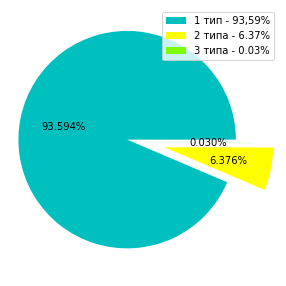

1    6239
2     425
3       2
Name: ImageId, dtype: int64


In [8]:
#Изображения могут содержать от одного до трех дефектов. Посмотрим как распределяются изображения в зависимости от количества дефектов

class_count = df.ImageId.value_counts().value_counts()
explode = (0.15, 0.2, 0)
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(class_count.values, explode=explode, autopct='%1.3f%%',colors=["c", "yellow", "lawngreen"])
plt.legend(['1 тип - 93,59%','2 типа - 6.37%','3 типа - 0.03%', ], loc="best")
plt.show()
print(class_count)

In [9]:
#В выборке есть много изображений, которые не содержат дефектов. Добавим их в нашу таблицу
for name in os.listdir(train_data):  
  if name not in df.ImageId.values:
    new_row = {'ImageId':  name, 'ClassId': 0, 'EncodedPixels': '1 409600'}
    df = df.append(new_row, ignore_index=True)

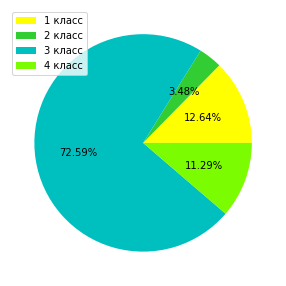

1     897
2     247
3    5150
4     801
Name: ClassId, dtype: int64


In [10]:
#Посмотрим на распределение изображений по классу дефекта
defect_count = df.ClassId.value_counts().sort_index()[1:]
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(defect_count.values, autopct='%1.2f%%',colors=["yellow", "limegreen", "c", "lawngreen"])
plt.legend(['1 класс','2 класс','3 класс','4 класс'], loc="best")
plt.show()

print(defect_count)

In [11]:
#Добавим в таблицу столбец с меткой есть ли дефект или нет
df['defect'] = np.zeros(df.shape[0])
df.loc[df.ClassId != 0, 'defect'] = 1

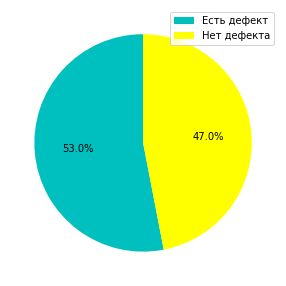

1.0    6666
0.0    5902
Name: defect, dtype: int64


In [12]:
#Посмотрим на распределение изображений в зависимости от наличия дефектов
image_count = df.drop_duplicates(subset ="ImageId").defect.value_counts()
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(image_count.values, autopct='%1.1f%%',colors=["c", "yellow"],startangle=90)
plt.legend(['Есть дефект','Нет дефекта'], loc="best")
plt.show()

print(image_count)

In [13]:
pixel_class1 = np.sum([np.array(pixels.split(), dtype=np.int32)[1::2].sum() for pixels in df.loc[df.ClassId==1, 'EncodedPixels'].values])
pixel_class2 = np.sum([np.array(pixels.split(), dtype=np.int32)[1::2].sum() for pixels in df.loc[df.ClassId==2, 'EncodedPixels'].values])
pixel_class3 = np.sum([np.array(pixels.split(), dtype=np.int32)[1::2].sum() for pixels in df.loc[df.ClassId==3, 'EncodedPixels'].values])
pixel_class4 = np.sum([np.array(pixels.split(), dtype=np.int32)[1::2].sum() for pixels in df.loc[df.ClassId==4, 'EncodedPixels'].values])

print('Количество пикселей 1 класса: ', pixel_class1)
print('Количество пикселей 2 класса: ', pixel_class2)
print('Количество пикселей 3 класса: ', pixel_class3)
print('Количество пикселей 4 класса: ', pixel_class4)
print('Количество пикселей без дефектов: ', 2742524929)

Количество пикселей 1 класса:  3912129
Количество пикселей 2 класса:  834471
Количество пикселей 3 класса:  131306899
Количество пикселей 4 класса:  27533572
Количество пикселей без дефектов:  2742524929


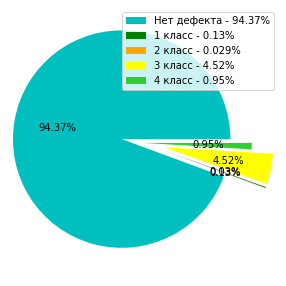

In [14]:
fig1, ax1 = plt.subplots(figsize=(5,5))
explode = (0.2, 0.2, 0.2, 0.2, 0)
ax1.pie([2742524929, pixel_class1, pixel_class2, pixel_class3, pixel_class4], autopct='%1.2f%%',colors=["c", "g", "orange", "yellow", "limegreen"], explode=explode)
plt.legend(['Нет дефекта - 94.37%', '1 класс - 0.13%','2 класс - 0.029%','3 класс - 4.52%','4 класс - 0.95%'], loc="best")
plt.show()


Видно, что выборка несбалансирована. Очень много дефектов 3 класса и мало 2 класса. 
Одним из пожеланий организатора соревнования была скорость работы модели.   Потому что на один рулон металла приходятся тысячи изображений, а темпы производства таковы, что на оценку качества всего рулона нет и пяти минут.

По логике, на производстве большая часть продукции будет без дефектов. Поэтому можно обучить классификатор, который сразу будет отбирать изображения с дефектами.

Для детекции дефектов будем использовать архитектуру LinkNet.

Идея заключается в том, чтобы использовать классификатор как backbone для сети LinkNet и, в случае обнаружения дефекта, не выполнять повторно вычисления по кодированию.

### Получение маски дефекта

In [15]:
# !mkdir '/content/drive/MyDrive/Северсталь/mask_data'

In [16]:
#Переведем попиксельное представление маски в изображение
def get_mask(name, img_data):
  mask = np.zeros(1600*256)
  for class_id, pixels in img_data.loc[img_data.ImageId == name, ['ClassId','EncodedPixels']].values:
    if class_id == 0: #Если дефектов нет, оставляем нули в маске
      break
    pixels = np.array(pixels.split(), dtype=np.int32) #получаем данные из соответствующего столбца
    pixels[1::2] += pixels[::2] #получаем индексы окончания строки маски 
    for i in range(0,len(pixels),2):
      mask[pixels[i]:pixels[i+1]] += class_id #ставим номер класса в нужных пикселях
  mask = mask.reshape(1600,256).T
  return mask


Проверим как работает функция

In [17]:
name = 'a9f605949.jpg'

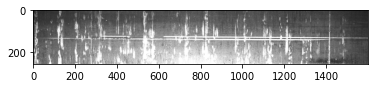

In [18]:
img = Image.open(train_data + name)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

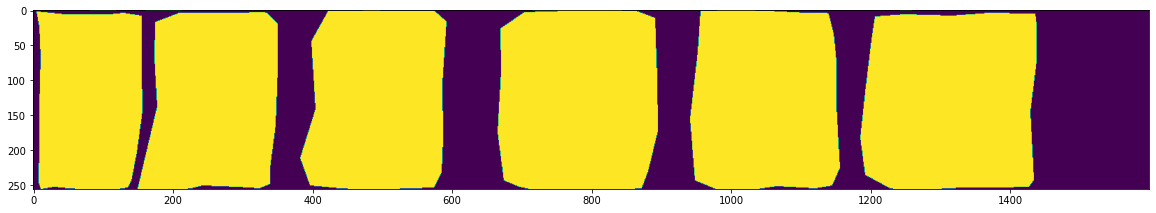

In [19]:
img = get_mask(name, df)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

### Разделение на обучающую и тестовую выборки

Так как распределение классов дефектов несбалансированы, будет делать разные обучающие выборки для классификатора и модели сегментации. В тестовую выборку отберем изображения 20% изображенией с сохранением распределения по классам и количеству дефектов на изображении 

In [20]:
count_to_img = df.ImageId.value_counts()
test_seg = [] #тестовая выборка для задачи сегментации
test_seg.extend(count_to_img[count_to_img==2][:85].index.values) #добавим изображения с двумя дефектами

In [21]:
#посмотрим какое получилось распределение по класам дефектов
df.loc[df.ImageId.isin(test_seg)].ClassId.value_counts()

3    80
4    59
1    23
2     8
Name: ClassId, dtype: int64

In [22]:
df_to_split = df.loc[~df.ImageId.isin(test_seg)] #отберем изображения, которых еще нет в тестовой выборке
#добавим недостающее количество изображений в выборку
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 1, 'ImageId'][:153].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 2, 'ImageId'][:39].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 3, 'ImageId'][:951].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 4, 'ImageId'][:113].values)

#создадим тестовую выборку для классификатора
test=test_seg.copy()
test.extend(df_to_split.loc[df_to_split.ClassId == 0, 'ImageId'][:1180].values)

In [23]:
df.loc[df.ImageId.isin(test_seg)].ClassId.value_counts()

3    1031
1     178
4     178
2      49
Name: ClassId, dtype: int64

In [24]:
df_to_seg = df.loc[~df.ImageId.isin(test)] #убираем из набора данных тестовые изображения 

# df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 3].index[:3331], axis=0, inplace=True) #делаем undersampling
df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 0].index[:], axis=0, inplace=True) #убираем изображения без дефектов

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
#отбираем названия изображений для обучающей выборки модели сегментации
train_seg = df_to_seg.loc[~df_to_seg.ImageId.isin(test), 'ImageId'].values

In [26]:
#посмотрим на распределение классов в обучающей выборке
df.loc[df.ImageId.isin(train_seg)].ClassId.value_counts()

3    4119
1     719
4     623
2     198
Name: ClassId, dtype: int64

In [27]:
#отбираем названия изображений для обучающей выборки классификатора
train = df.loc[~df.ImageId.isin(test), 'ImageId'].values

In [28]:
train_seg = list(set(train_seg))
test_seg = list(set(test_seg))
train = list(set(train))
test = list(set(test))

In [29]:
print('Обучающая выборка для сегментации: ', len(train_seg))
print('Валидационная выборка для сегментации: ', len(test_seg))
print('Обучающая выборка для классификатора: ', len(train))
print('Валидационная выборка для классификатора: ', len(test))

Обучающая выборка для сегментации:  5376
Валидационная выборка для сегментации:  1290
Обучающая выборка для классификатора:  10098
Валидационная выборка для классификатора:  2470


### Создание генератора данных

In [44]:
!pip install albumentations
import albumentations as A

transform_clf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-10,10), p=0.25,),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

normalize = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Создадим два генератора - для сегментации и классификации

In [31]:
class DataGeneratorSeg(Sequence):
    
    def __init__(self, img_name, img_data, batch_size=8, shuffle=True, aug=True, seg=True):
        'Initialization'
        self.img_name = img_name        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_data = img_data
        self.aug = aug
        self.seg = seg
        self.on_epoch_end()

    def __len__(self):
        #Получаем количество эпох
        return int(np.floor(len(self.img_name) / self.batch_size))

    def __getitem__(self, index):        
        # Получаем индекса батча данных
        list_IDs_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Получаем данные по индексу
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Обновляем и перемешиваем индексы в конце каждой эпохи 
        self.indexes = np.arange(len(self.img_name))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def augmentations(self, image, label):
         #Выполняем аугментацию
        if self.aug:
            transformed = transform(image=image, mask=label) 
            img = transformed['image']
            label = transformed['mask']
        return img, label


    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            #Загружаем данные и меняем размер изображений
            path_img = '/content/train_images/'+self.img_name[i]
            img = cv2.imread(path_img)/255
            label = get_mask(self.img_name[i], self.img_data)
            
                      
            for part in range(5):
                img_part = img[:,320*part:320*(part+1),:]
                label_part = label[:,320*part:320*(part+1)]                
                img_aug, label_aug = self.augmentations(img_part, label_part)                                                
                if self.seg: #Если обучаем сегментации, делаем One-Hot-Encoding маски и добавляем в список
                    if label_aug.sum():
                        label_ohe = np.zeros((256,320,4))
                        for i in range(4):
                            label_ohe[:,:,i] = (label_aug==i+1).astype(np.int32, copy=False)
                        batch_labels.append(label_ohe)
                        batch_imgs.append(img_aug)
                else:
                    label_clf = 1 if label_aug.sum() else 0
                    batch_labels.append(label_clf)          
                    batch_imgs.append(img_aug)
                   
        return np.array(batch_imgs), np.array(batch_labels)


In [32]:
#Создаем генераторы для обучающих и тестовых выборок
train_gen_seg = DataGeneratorSeg(train_seg, df)
test_gen_seg = DataGeneratorSeg(test_seg, df, aug=False)

train_gen_clf = DataGeneratorSeg(train, df, seg=False)
test_gen_clf = DataGeneratorSeg(test, df, seg=False, aug=False)

### Создание и обучение моделей

In [33]:
#Задаем метрику и функцию потерь

# Функция считает степень пересечения настоящей и предсказанной маски
def dice_coef(true, pred):
  return (2 * K.sum(true*pred)+1) / (K.sum(true) + K.sum(pred)+1)

# Функция потерь составная
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 0.25*(1-dice_coef(y_true, y_pred))



#### Классификатор

In [34]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 


In [35]:
from segmentation_models import Linknet
linknet = Linknet(backbone_name='efficientnetb2', classes=4, encoder_weights=None, encoder_freeze=False)


Segmentation Models: using `keras` framework.


In [36]:
#Добавим нужный выход модели
x = linknet.layers[331].output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

clf = Model(linknet.input, output)

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Северсталь/best_clf_v3.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [38]:
# for layer in linknet.layers:
#     layer.trainable = False

In [ ]:
clf.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = clf.fit(train_gen_clf, validation_data=test_gen_clf, epochs=20, callbacks=callbacks)

In [ ]:
# loss = [0.3264, 0.3073, 0.2873, 0.2700, 0.2576, 0.2474, 0.2362, 0.2280, 0.2218, 0.2123, 0.2128, 0.2043, 0.1991, 0.1941, 0.1947, 0.1966, 0.1897, 0.1832, 0.1773,
#         0.1832, 0.1784, 0.1702, 0.1693, 0.1702, 0.1669, 0.1480, 0.1397, 0.1397, 0.1350, 0.1336, 0.1338, 0.1314, 0.1296, 0.1330, 0.1295, 0.1314, 0.1281, 0.1261]

# accuracy = [0.8612, 0.8730, 0.8817, 0.8893, 0.8995, 0.9024, 0.9079, 0.9114, 0.9135, 0.9171, 0.9176, 0.9199, 0.9222, 0.9250, 0.9258, 0.9226, 0.9273, 0.9296, 0.9303, 0.9313,
#             0.9279, 0.9313, 0.9341, 0.9342, 0.9348, 0.9362, 0.9460, 0.9462, 0.9490, 0.9483, 0.9496, 0.9494,  0.9496, 0.9490, 0.9499, 0.9503, 0.9504, 0.9514]

# val_loss = [0.2619, 0.2681, 0.2446, 0.2339, 0.2325, 0.2285, 0.2228, 0.2134, 0.2037, 0.1906, 0.1932, 0.1911, 0.1962, 0.1973, 0.1945, 0.1929, 0.1908, 0.1850, 0.1755, 0.1745,
#             0.1731, 0.1715, 0.1714, 0.1642, 0.1657, 0.1638, 0.1582, 0.1565, 0.1531, 0.1524, 0.1503, 0.1491, 0.1482, 0.1459, 0.1476, 0.1472, 0.1456, 0.1470]            

# val_accuracy = [0.8907, 0.8870, 0.9022, 0.9051, 0.9048, 0.9149, 0.9094, 0.9143, 0.9171, 0.9246, 0.9206, 0.9214, 0.9167, 0.9328, 0.9292, 0.9245, 0.9249, 0.9270, 0.9313, 0.9406,
#                 0.9323, 0.9309, 0.9316, 0.9366, 0.9348, 0.9326, 0.9413, 0.9406, 0.9406, 0.9409, 0.9412, 0.9419, 0.9410, 0.9431, 0.9420, 0.9429, 0.9427, 0.9437]

# history = {'loss':loss, 'accuracy':accuracy, 'val_loss':val_loss, 'val_accuracy':val_accuracy}

In [40]:
# clf.save_weights('/content/drive/MyDrive/Северсталь/best_clf_v2.hdf5')
clf.load_weights('/content/drive/MyDrive/Северсталь/best_clf_4.hdf5')

In [ ]:
clf.save('clf4.h5')

In [ ]:
#Функция выводит графики обучения модели
def plot_history(history, num_epoch):
  plt.figure(figsize=(18, 6))
  name = list(history.keys())
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(history[name[i]])
    plt.plot(history[name[i+2]])
    plt.xlabel("Эпоха")
    plt.ylabel("{}".format(name[i]))
    plt.xticks(range(0,num_epoch, 5))
    plt.legend(['Обучающая выборка','Тестовая выборка'])
  plt.show()

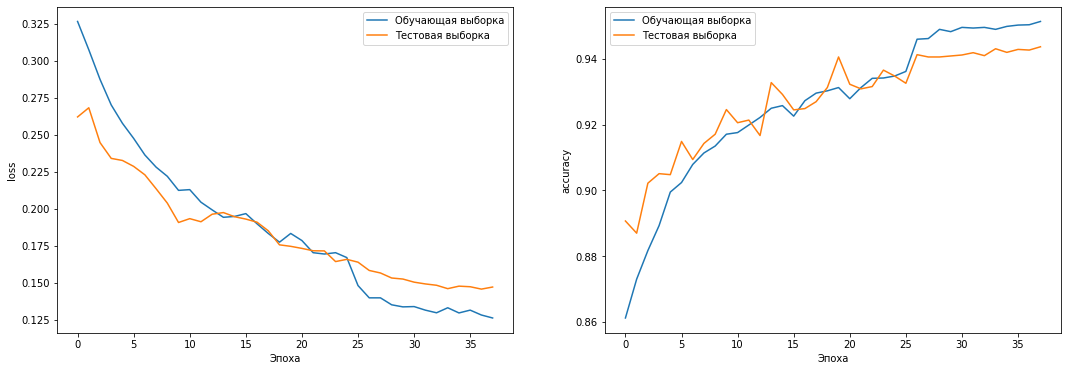

In [ ]:
plot_history(history, 38)

### Cегментация

In [ ]:
save_callback = ModelCheckpoint('/content/drive/MyDrive/Северсталь/best_linknet_v4.hdf5', monitor='val_dice_coef', verbose=1,
                                save_best_only=True, mode='max')
callbacks = [lr_callback, save_callback]

In [ ]:
class_weight=[1., 10., 0.05, 0.25]

In [ ]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(np.int64(i), classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
linknet.compile(optimizer=Adam(0.0001), loss=weightedLoss(bce_dice_loss, class_weight), metrics=[dice_coef])
history = linknet.fit(train_gen_seg, validation_data=test_gen_seg, epochs=60, callbacks=callbacks)

Epoch 1/60
707/707 [==============================] - ETA: 0s - loss: 0.5664 - dice_coef: 0.6963
Epoch 1: val_dice_coef improved from -inf to 0.69691, saving model to /content/drive/MyDrive/Северсталь/best_linknet_v3.hdf5
707/707 [==============================] - 500s 689ms/step - loss: 0.5664 - dice_coef: 0.6963 - val_loss: 0.5786 - val_dice_coef: 0.6969 - lr: 1.0000e-04
Epoch 2/60
610/707 [========================>.....] - ETA: 1:01 - loss: 0.5561 - dice_coef: 0.7025

In [ ]:
# loss = [0.3231, 0.2068, 0.1964, 0.1899, 0.1854, 0.1829, 0.1780, 0.1746, 0.1744, 0.1714, 0.1694, 0.1676, 0.1661, 0.1659, 0.1649, 0.1634, 0.1613,
#         0.1537, 0.1541, 0.1530, 0.1521, 0.1532, 0.1517, 0.1528, 0.1513, 0.1517, 0.1518, 0.1503, 0.1518, 0.1510, 0.1487, 0.1498,
#         0.1973, 0.1939, 0.1930, 0.1908, 0.1917, 0.1900,
#         0.2037, 0.1899, 0.1815, 0.1760, 0.1706, 0.1671, 0.1627, 0.1623, 0.1603, 0.1573, 0.1592, 0.1532, 0.1507, 0.1483, 0.1494, 0.1445, 0.1428, 0.1452, 
#         0.1300, 0.1277, 0.1290, 0.1255 ]

# dice_coef = [0.3812, 0.4817, 0.5115, 0.5446, 0.5740, 0.5940, 0.6015, 0.6086, 0.6172, 0.6315, 0.6340, 0.6229, 0.6472, 0.6394, 0.6574, 0.6585, 0.6662, 0.6662,
#              0.6624, 0.6735, 0.6768, 0.6785, 0.6830, 0.6842, 0.6844, 0.6852, 0.6922, 0.6862, 0.6908, 0.6998, 0.6946, 0.7053, 0.7058, 0.6979,
#             0.7255, 0.7282, 0.7333, 0.7347, 0.7329, 0.7348, 0.7401, 0.7401, 0.7379, 0.7401, 0.7401, 0.7433, 0.7405, 0.7433, 0.7449, 0.7420, 0.7432, 0.7437,
#              0.7439, 0.7459, 0.7437, 0.7471, 0.7449, 0.7455, 0.7484, 0.7504]

# val_loss = [0.2350, 0.1842, 0.1785, 0.1872, 0.1796, 0.1852, 0.1723, 0.1905, 0.1709, 0.1717, 0.1615, 0.1801, 0.1802, 0.1719, 0.1803, 0.1695, 0.1592,
#             0.1620, 0.1622, 0.1564, 0.1604, 0.1605, 0.1576, 0.1619, 0.1593, 0.1611, 0.1651, 0.1635, 0.1588, 0.1634, 0.1589, 0.1589,
#             0.2016, 0.2033, 0.2028, 0.2014, 0.1967, 0.2039,
#             0.2183, 0.1759, 0.1772, 0.1630, 0.1597, 0.1684, 0.1609, 0.1541, 0.1643, 0.1683, 0.1568, 0.1451, 0.1433, 0.1477, 0.1560, 0.1448, 0.1536, 0.1648,
#             0.1417, 0.1380, 0.1378, 0.1368 ]

# val_dice_coef = [0.2919, 0.4879, 0.5223, 0.4698, 0.5438, 0.6182, 0.6363, 0.6243, 0.6401, 0.6471, 0.6177, 0.6668, 0.6656, 0.6194, 0.6609, 0.6707, 0.6458, 0.6609,
#                  0.6806, 0.6829, 0.6728, 0.6766, 0.6701, 0.6695, 0.6721, 0.6826, 0.6828, 0.7025, 0.6790, 0.7089, 0.6878, 0.7012, 0.6893, 0.6669,
#                  0.7172, 0.7181, 0.7282, 0.7219, 0.7205, 0.7247, 0.7159, 0.7159, 0.7209, 0.7202, 0.7244, 0.7295, 0.7291, 0.7256, 0.7228, 0.7218, 0.7278, 0.7244,
#                  0.7283, 0.7261, 0.7208, 0.7282, 0.7283, 0.7297, 0.7313, 0.7322]

                 
# history = {'loss':loss, 'dice_coef':dice_coef, 'val_loss':val_loss, 'val_dice_coef':val_dice_coef}

In [66]:
# linknet.save_weights('/content/drive/MyDrive/Северсталь/best_linknet.hdf5')
linknet.load_weights('/content/drive/MyDrive/Северсталь/best_linknet_v4.hdf5')

In [ ]:
linknet.save('link_best.h5')

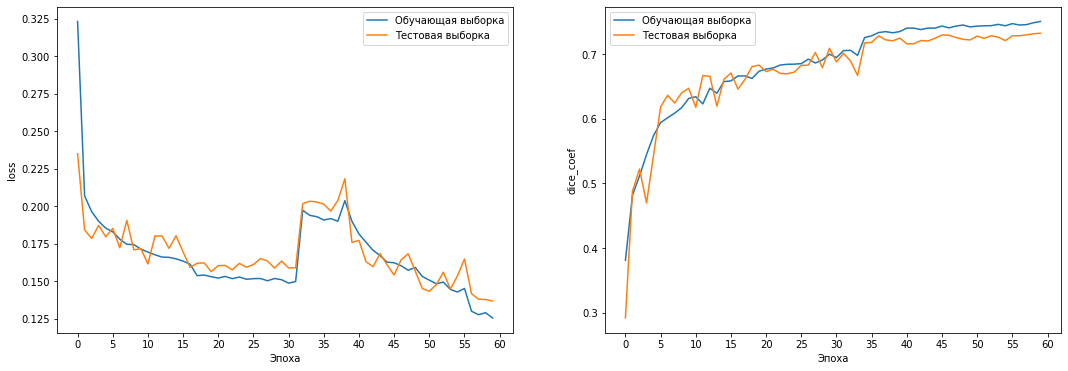

In [ ]:
plot_history(history, 65)

In [ ]:
def get_predict(orig_img):

    
    img_part=[]
    for part in range(5):
        img_part.append(orig_img[:,320*part:320*(part+1),:]) 
    pred_clf = clf.predict(np.array(img_part))
    if np.sum(pred_clf > 0.7)+1:
        pred_seg = linknet.predict(np.array(img_part))
        full_pred = np.hstack([pred_seg[0],pred_seg[1],pred_seg[2],pred_seg[3],pred_seg[4]])
        pred_mask = (full_pred > 0.5).astype(np.int32)
        pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
        pred_mask = pred_mask.astype(np.float32)

    else: pred_mask = np.zeros((256,1600))

    return pred_mask


In [ ]:
def plot_predict(list_name):
  n = random.randint(0, 1000)
  name = list_name[n]
  # name = '49fa7d0fa.jpg'
  path_img = '/content/train_images/' + name
  orig_img = cv2.imread(path_img)/255 
  mask = get_mask(name, df)
  pred_mask = get_predict(orig_img)

  plt.figure(figsize=(30, 15))
  plt.subplot(3,1,1)
  plt.imshow(orig_img)
  plt.title('Оригинальное изображение')
  plt.subplot(3,1,2)
  plt.imshow(mask, cmap='jet')
  plt.title('Настоящая маска')
  plt.subplot(3,1,3)
  plt.imshow(pred_mask, cmap='jet')
  plt.title('Предсказаная маска')

  plt.show()
  

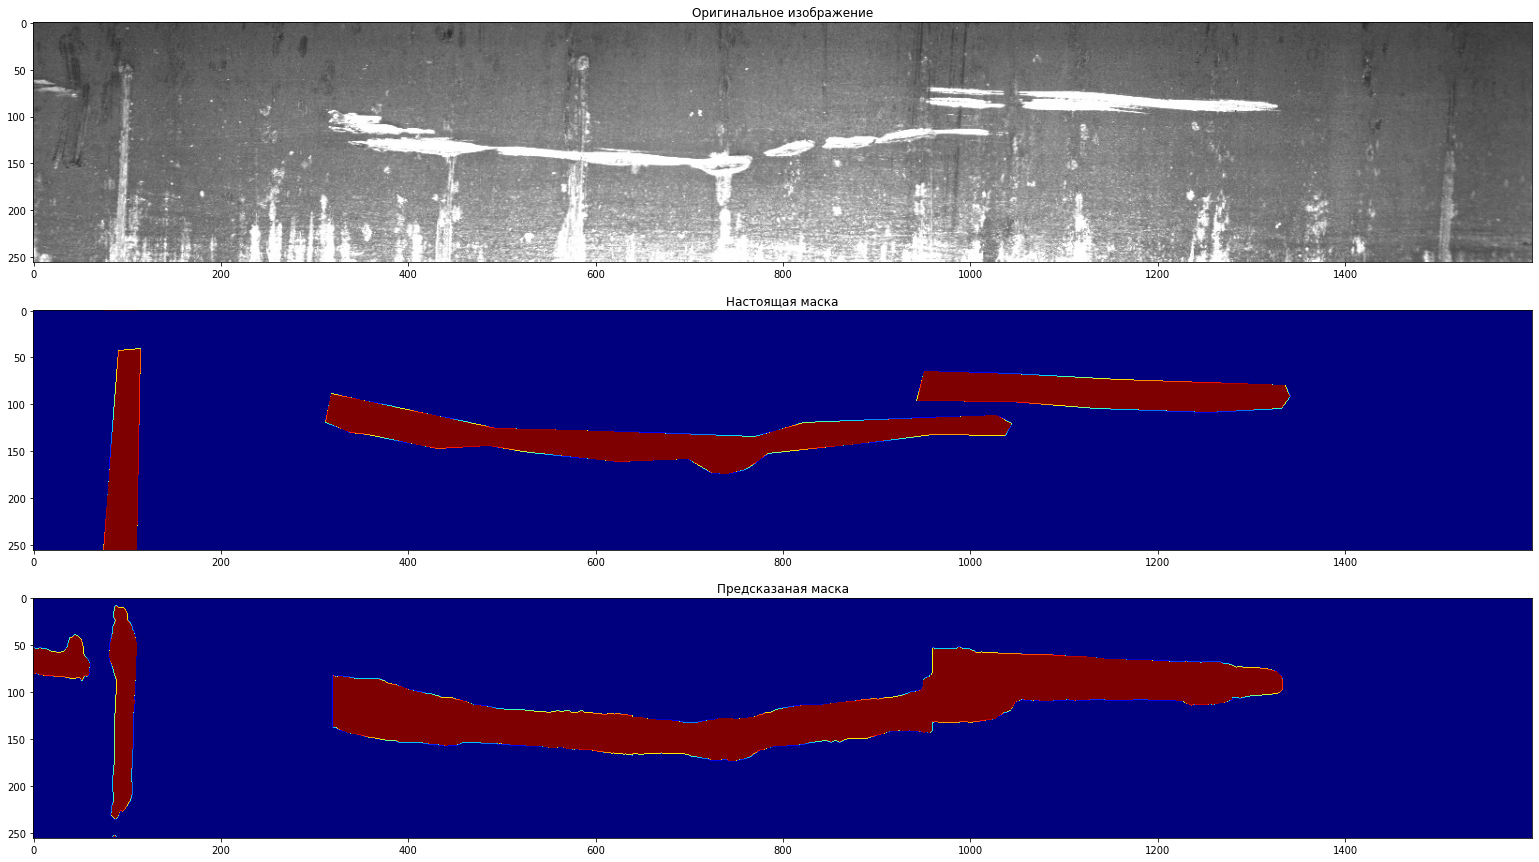

In [ ]:
plot_predict(test_seg)

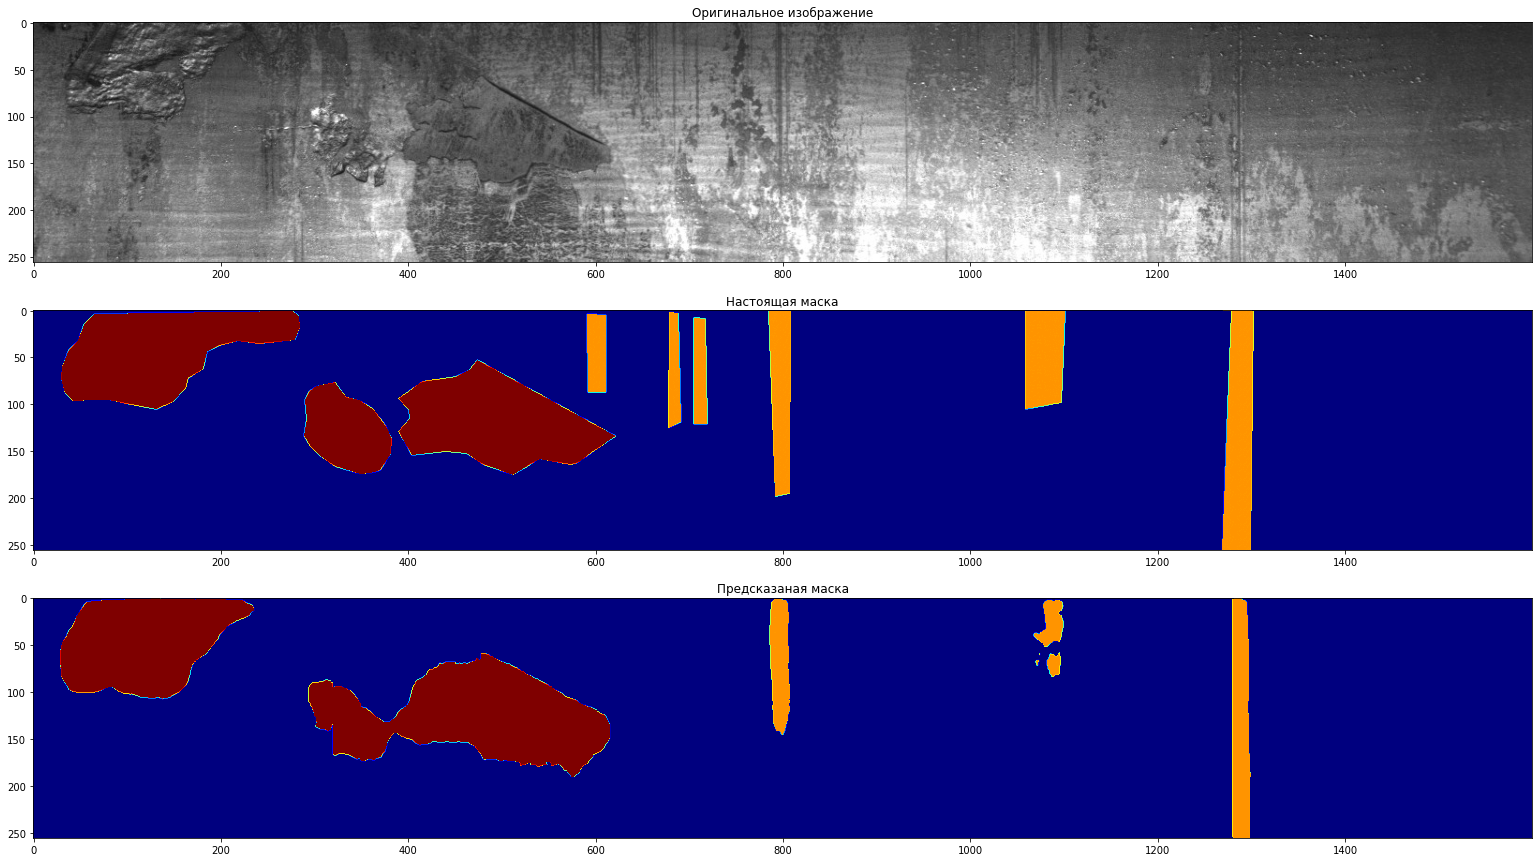

In [ ]:
plot_predict(test_seg)

## Объединенная модель

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.763782 to fit



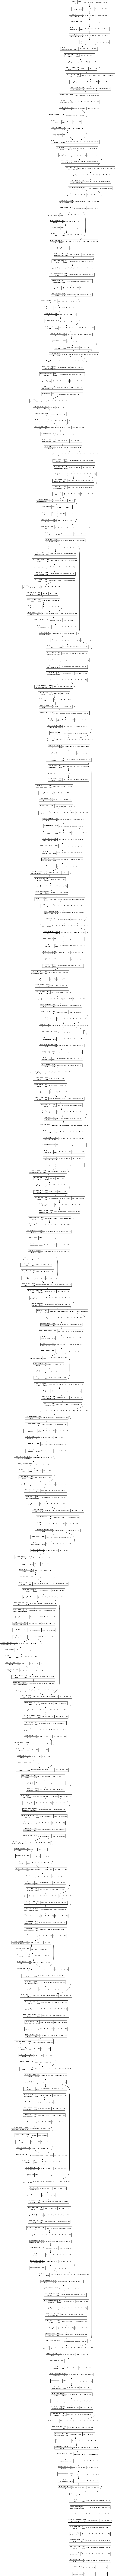

In [ ]:
#Посмотрим какие сли мы можем передать в модель сегментации
from tensorflow.keras.utils import plot_model
plot_model(linknet, show_shapes=True)

In [ ]:
clf_part = Model(clf.input, [clf.layers[28].output, 
                             clf.layers[71].output, 
                             clf.layers[114].output, 
                             clf.layers[230].output, 
                             clf.layers[331].output, 
                             clf.output])


input_1 = Input(linknet.layers[375].input_shape[0][1:])
input_2 = Input(linknet.layers[364].input_shape[0][1:])
input_3 = Input(linknet.layers[353].input_shape[0][1:])
input_4 = Input(linknet.layers[342].input_shape[0][1:])
input_5 = Input((None, None, 1408))

input_list=[input_1, input_2, input_3, input_4, input_5]



x = linknet.layers[332](input_list.pop())

for layer in linknet.layers[333:335]:
    if layer.name[-4:] == '_add':
        x = layer([x, input_list.pop()])
    else:
        x = layer(x)

seg_part = Model([input_1, input_2, input_3, input_4, input_5], x)

In [ ]:
clf_part.save('clf_part.h5')
seg_part.save('seg_part.h5')

In [ ]:
%%time
# вариант из двух отдельных сетей
random.shuffle(test)
for j, i in enumerate(test):
    orig_img = cv2.imread(train_data + i)
    orig_img = normalize(image=orig_img)['image']
    mask = get_mask(i, df)
    img_part=[]
    for part in range(5):
        img_part.append(orig_img[:,320*part:320*(part+1),:]) 
  
    pred = clf.predict(np.array(img_part))
    if (pred>0.7).sum():

        pred_seg = linknet.predict(np.array(img_part))
        full_pred = np.hstack([pred_seg[0],pred_seg[1],pred_seg[2],pred_seg[3],pred_seg[4]])

        pred_mask = (full_pred > 0.5).astype(np.int32)
        pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
        pred_mask = pred_mask.astype(np.float32)
        pred_mask[(pred_mask != 1) & (pred_mask != 2) & (pred_mask != 3) & (pred_mask != 4)] = 0 

CPU times: user 6min 9s, sys: 7.47 s, total: 6min 17s
Wall time: 6min 17s


In [ ]:
%%time
# вариант из двух сетей с общей частью

random.shuffle(test)
for j, i in enumerate(test):
    orig_img = cv2.imread(train_data + i)
    orig_img = normalize(image=orig_img)['image']
    mask = get_mask(i, df)
    img_part=[]
    for part in range(5):
        img_part.append(orig_img[:,320*part:320*(part+1),:]) 
  
    output_1, output_2 ,output_3 ,output_4 ,output_5, pred = clf_part.predict(np.array(img_part))
    if (pred>0.7).sum():

        pred_seg = seg_part.predict([output_1, output_2 ,output_3 ,output_4 ,output_5])
        full_pred = np.hstack([pred_seg[0],pred_seg[1],pred_seg[2],pred_seg[3],pred_seg[4]])

        pred_mask = (full_pred > 0.5).astype(np.int32)
        pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
        pred_mask = pred_mask.astype(np.float32)
        pred_mask[(pred_mask != 1) & (pred_mask != 2) & (pred_mask != 3) & (pred_mask != 4)] = 0 

  

In [141]:
if s is None:
  print(33)

33


In [140]:
s = cv2.imread('/content/train_images/000418bfc.txt')

In [132]:
s = cv2.imread('/content/train_images/000418bfc.jpg')

In [137]:
if type(s)== numpy.ndarray:
  print(33)

NameError: ignored

In [127]:
s  = np.ones((23,45,67))

In [130]:
type(s) 

numpy.ndarray